In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
transaction_agg = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending per customer
    'TransactionID': 'count',  # Number of transactions
    'Quantity': 'sum'  # Total quantity purchased
}).reset_index()
transaction_agg

,CustomerID,TotalValue,TransactionID,Quantity
0,C0001,3354.52,5,12
1,C0002,1862.74,4,10
2,C0003,2725.38,4,14
3,C0004,5354.88,8,23
4,C0005,2034.24,3,7
...,...,...,...,...
194,C0196,4982.88,4,12
195,C0197,1928.65,3,9
196,C0198,931.83,2,3
197,C0199,1979.28,4,9


In [4]:
transaction_agg.rename(columns={
    'TotalValue': 'TotalSpending',
    'TransactionID': 'TransactionCount',
    'Quantity': 'TotalQuantity'
}, inplace=True)
transaction_agg

,CustomerID,TotalSpending,TransactionCount,TotalQuantity
0,C0001,3354.52,5,12
1,C0002,1862.74,4,10
2,C0003,2725.38,4,14
3,C0004,5354.88,8,23
4,C0005,2034.24,3,7
...,...,...,...,...
194,C0196,4982.88,4,12
195,C0197,1928.65,3,9
196,C0198,931.83,2,3
197,C0199,1979.28,4,9


In [5]:
customer_data = pd.merge(customers, transaction_agg, on='CustomerID', how='inner')
customer_data

,CustomerID,CustomerName,Region,SignupDate,TotalSpending,TransactionCount,TotalQuantity
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5,12
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4,10
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4,14
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8,23
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3,7
...,...,...,...,...,...,...,...
194,C0196,Laura Watts,Europe,2022-06-07,4982.88,4,12
195,C0197,Christina Harvey,Europe,2023-03-21,1928.65,3,9
196,C0198,Rebecca Ray,Europe,2022-02-27,931.83,2,3
197,C0199,Andrea Jenkins,Europe,2022-12-03,1979.28,4,9


In [6]:
customer_features = customer_data.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1)
customer_features

,Region,TotalSpending,TransactionCount,TotalQuantity
0,South America,3354.52,5,12
1,Asia,1862.74,4,10
2,South America,2725.38,4,14
3,South America,5354.88,8,23
4,Asia,2034.24,3,7
...,...,...,...,...
194,Europe,4982.88,4,12
195,Europe,1928.65,3,9
196,Europe,931.83,2,3
197,Europe,1979.28,4,9


In [7]:
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

In [8]:
customer_features

,TotalSpending,TransactionCount,TotalQuantity,Region_Europe,Region_North America,Region_South America
0,3354.52,5,12,False,False,True
1,1862.74,4,10,False,False,False
2,2725.38,4,14,False,False,True
3,5354.88,8,23,False,False,True
4,2034.24,3,7,False,False,False
...,...,...,...,...,...,...
194,4982.88,4,12,True,False,False
195,1928.65,3,9,True,False,False
196,931.83,2,3,True,False,False
197,1979.28,4,9,True,False,False


In [9]:
scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features)
customer_features_scaled

array([[-0.06170143, -0.01145819, -0.12203296, -0.57928445, -0.54831888,
         1.54041597],
       [-0.87774353, -0.46749414, -0.44800021, -0.57928445, -0.54831888,
        -0.6491753 ],
       [-0.40585722, -0.46749414,  0.20393428, -0.57928445, -0.54831888,
         1.54041597],
       ...,
       [-1.38697529, -1.37956603, -1.58888557,  1.72626765, -0.54831888,
        -0.6491753 ],
       [-0.81399315, -0.46749414, -0.61098383,  1.72626765, -0.54831888,
        -0.6491753 ],
       [ 0.70636652, -0.01145819,  0.52990153, -0.57928445, -0.54831888,
        -0.6491753 ]])

In [10]:
db_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(customer_features_scaled)
    db_index = davies_bouldin_score(customer_features_scaled, clusters)
    db_scores.append(db_index)

db_scores

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  

[1.449390727020293,
 1.1988522183883534,
 0.9880667545355787,
 0.9384521529981805,
 0.908018537867124,
 0.960254215567246,
 0.837051207078169,
 0.7918875485993543,
 0.79002838575684]

In [11]:
db_scores

[1.449390727020293,
 1.1988522183883534,
 0.9880667545355787,
 0.9384521529981805,
 0.908018537867124,
 0.960254215567246,
 0.837051207078169,
 0.7918875485993543,
 0.79002838575684]

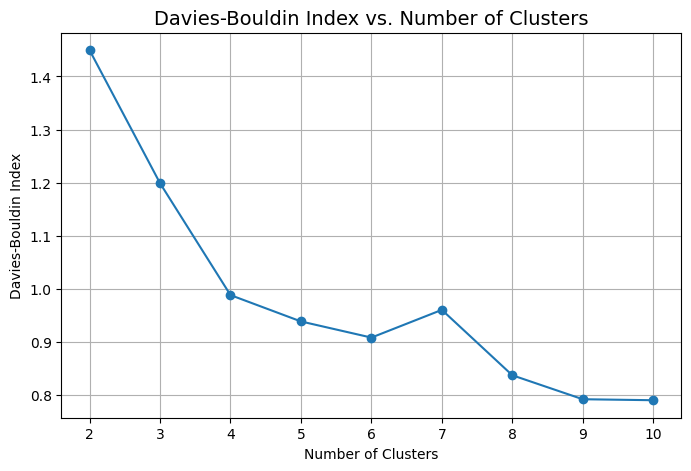

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, db_scores, marker='o')
plt.title('Davies-Bouldin Index vs. Number of Clusters', fontsize=14)
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.grid(True)
plt.show()

In [13]:
optimal_k = k_values[np.argmin(db_scores)]
print(f"Optimal number of clusters: {optimal_k}")

Optimal number of clusters: 10


In [14]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_features_scaled)
customer_data

,CustomerID,CustomerName,Region,SignupDate,TotalSpending,TransactionCount,TotalQuantity,Cluster
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5,12,1
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4,10,6
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4,14,1
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8,23,8
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3,7,6
...,...,...,...,...,...,...,...,...
194,C0196,Laura Watts,Europe,2022-06-07,4982.88,4,12,7
195,C0197,Christina Harvey,Europe,2023-03-21,1928.65,3,9,3
196,C0198,Rebecca Ray,Europe,2022-02-27,931.83,2,3,3
197,C0199,Andrea Jenkins,Europe,2022-12-03,1979.28,4,9,3


In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
customer_data_pca = pca.fit_transform(customer_features_scaled)
customer_data['PCA1'] = customer_data_pca[:, 0]
customer_data['PCA2'] = customer_data_pca[:, 1]

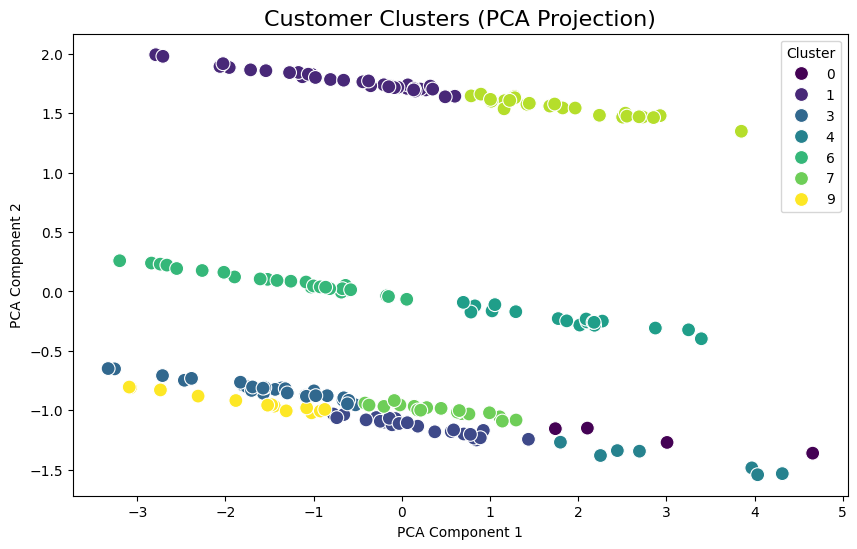

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', 
    y='PCA2', 
    hue='Cluster', 
    palette='viridis', 
    data=customer_data, 
    s=100
)

plt.title('Customer Clusters (PCA Projection)', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [17]:
final_db_index = davies_bouldin_score(customer_features_scaled, customer_data['Cluster'])

In [18]:
cluster_summary = customer_data.groupby('Cluster').agg({
    'TotalSpending': 'mean',
    'TransactionCount': 'mean',
    'TotalQuantity': 'mean'
}).reset_index()

In [19]:
print(f"Davies-Bouldin Index for final clusters: {final_db_index}")
print("\nCluster Summary:")
print(cluster_summary)

Davies-Bouldin Index for final clusters: 0.79002838575684

Cluster Summary:
   Cluster  TotalSpending  TransactionCount  TotalQuantity
0        0    6856.610000          8.500000      24.750000
1        1    2561.333143          3.971429       9.371429
2        2    3334.220385          5.615385      12.961538
3        3    2056.031481          3.481481       7.814815
4        4    6244.077143          9.285714      24.142857
5        5    5379.353889          7.500000      19.611111
6        6    2124.869231          3.192308       7.961538
7        7    4385.017895          5.578947      15.000000
8        8    5404.412500          6.875000      19.208333
9        9    1685.779231          2.538462       6.692308
